In [1]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(42)

In [2]:
from torch.utils.data import Dataset
import os
from PIL import Image

from sklearn.metrics import jaccard_score as jsc

from transformers import SegFormerFeatureExtractor
from transformers import SegFormerConfig, SegFormerForImageClassification, SegFormerForImageSegmentation

from torch.utils.data import DataLoader

from transformers import AdamW
import torch
from tqdm.notebook import tqdm

from sklearn.metrics import jaccard_score as jsc

from torch import nn
import numpy as np
import matplotlib.pyplot as plt

import glob 

In [3]:
class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, root_dir, feature_extractor, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.feature_extractor = feature_extractor
        self.train = train

        sub_path = "training" if self.train else "validation"
        self.img_dir = os.path.join(self.root_dir, "images", sub_path)
        self.ann_dir = os.path.join(self.root_dir, "annotations", sub_path)
        
        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
          image_file_names.extend(files)
        self.images = sorted(image_file_names)
        
        # read annotations
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
          annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        
        image = Image.open(os.path.join(self.img_dir, self.images[idx]))
        segmentation_map = Image.open(os.path.join(self.ann_dir, self.annotations[idx]))

        encoded_inputs = self.feature_extractor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

In [4]:
#from transformers import SegFormerFeatureExtractor

root_dir =  'C:/Users/troyl/Desktop/courses/MRP\MY_PROJECT/Segformer/dataset/prepared_unaugmented_final'
#root_dir =  'C:/Users/troyl/Desktop/courses/MRP/MY_PROJECT/Segformer/dataset/sample'
feature_extractor = SegFormerFeatureExtractor(do_resize=True, align=False, reduce_zero_label=False)

train_dataset = ImageSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor)
valid_dataset = ImageSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor, train=False)

In [5]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))

Number of training examples: 8127
Number of validation examples: 2130


# Define DataLoaders

In [6]:
#from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=2)

In [7]:
#batch = next(iter(train_dataloader))

In [8]:
# for k,v in batch.items():
#   print(k, v.shape)

# Define the model

In [7]:
#from transformers import SegFormerConfig, SegFormerForImageClassification, SegFormerForImageSegmentation

model = SegFormerForImageClassification.from_pretrained("nielsr/mit-b0")

In [8]:
state_dict = model.state_dict()
# Remove ImageNet-1k class weights
del state_dict["classifier.weight"]
del state_dict["classifier.bias"]
# define new model 
config = SegFormerConfig.from_pretrained("nielsr/mit-b0", num_labels=2)
model = SegFormerForImageSegmentation(config)
model.load_state_dict(state_dict, strict=False)

_IncompatibleKeys(missing_keys=['linear_c.0.proj.weight', 'linear_c.0.proj.bias', 'linear_c.1.proj.weight', 'linear_c.1.proj.bias', 'linear_c.2.proj.weight', 'linear_c.2.proj.bias', 'linear_c.3.proj.weight', 'linear_c.3.proj.bias', 'linear_fuse.weight', 'batch_norm.weight', 'batch_norm.bias', 'batch_norm.running_mean', 'batch_norm.running_var', 'classifier.weight', 'classifier.bias'], unexpected_keys=[])

# Fine tune the model

In [9]:
from transformers import AdamW
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import time
import numpy as np


Epoch: 1  Training Loss: 0.480245  Validation Loss: 0.155817 



Epoch: 2  Training Loss: 0.311715  Validation Loss: 0.170912 



Epoch: 3  Training Loss: 0.280256  Validation Loss: 0.134473 



Epoch: 4  Training Loss: 0.260951  Validation Loss: 0.138554 



Epoch: 5  Training Loss: 0.242815  Validation Loss: 0.131506 
Total Training Time:  7301.752089262009


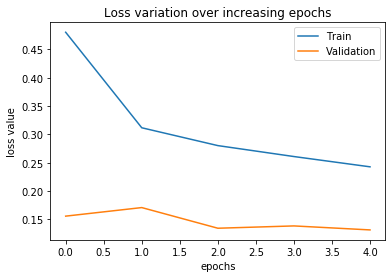

In [10]:
optimizer = AdamW(model.parameters(), lr=0.00006)
#optimizer = AdamW(model.parameters(), lr=0.000006)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


n_epochs = 5
train_loss_list = []
valid_loss_list = []
dice_score_list = []
lr_rate_list = []
valid_loss_min = np.Inf # track change in validation loss


start = time.time()

model.train()
for epoch in range(1, n_epochs+1):
    
    train_loss = 0.0
    valid_loss = 0.0
    dice_score = 0.0
    
    model.train()     # Optional when not using Model Specific layer
    for batch in tqdm(train_dataloader):
        
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values, labels=labels)
        
        loss = outputs.loss
        #print("Loss:", loss.item())
        loss.backward()
        optimizer.step()
        
        #train_loss_history.append(loss)
        #print(train_loss_history)
        
        train_loss += loss.item() * pixel_values.size(0)

    
  
    model.eval()
    del pixel_values, labels
    with torch.no_grad():
        for batch in tqdm(valid_dataloader):
        
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)
        
            output = model(pixel_values=pixel_values, labels=labels)
            loss = output.loss
            #print("Loss:", loss.item())
            valid_loss += loss.item() * pixel_values.size(0)
            
#             dice_cof = dice_no_threshold(output, labels).item()
#             dice_score +=  dice_cof * pixel_values.size(0)
            
            #val_loss_history.append(loss)
            #valid_loss += loss
        

    # calculate average losses
    train_loss = train_loss/len(train_dataloader)
    valid_loss = valid_loss/len(valid_dataloader)
    #dice_score = dice_score/len(valid_dataloader)
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    # dice_score_list.append(dice_score)        
  
        
    # print training/validation statistics 
    print('Epoch: {}  Training Loss: {:.6f}  Validation Loss: {:.6f} '.format(epoch, train_loss, valid_loss))        


end = time.time()
print("Total Training Time: ", end - start)




leg_lab = ["Train", "Validation"]
plt.plot(train_loss_list)
plt.plot(valid_loss_list)
plt.title('Loss variation over increasing epochs')
plt.xlabel('epochs')
plt.ylabel('loss value')
plt.legend(leg_lab)
plt.show()